In [ ]:
import io
import random
from PIL import Image
import numpy as np
import numpy as np
from PIL import Image, ImageOps, ImageEnhance

In [ ]:


# ImageNet code should change this value
IMAGE_SIZE = 224


def int_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .
  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
  Returns:
    An int that results from scaling `maxval` according to `level`.
  """
  return int(level * maxval / 10)


def float_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval.
  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
  Returns:
    A float that results from scaling `maxval` according to `level`.
  """
  return float(level) * maxval / 10.


def sample_level(n):
  return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
  return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
  return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
  level = int_parameter(sample_level(level), 4)
  return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
  degrees = int_parameter(sample_level(level), 30)
  if np.random.uniform() > 0.5:
    degrees = -degrees
  return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
  level = int_parameter(sample_level(level), 256)
  return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

In [ ]:
class APRecombination(object):
    def __init__(self, img_size=224, aug=None):
        if aug is None:
            IMAGE_SIZE = img_size
            self.aug_list = augmentations
        else:
            self.aug_list = aug.augmentations

    def __call__(self, x1,x_aug):
        '''
        :param img: (PIL Image): Image
        :return: code img (PIL Image): Image
        '''

        #op = np.random.choice(self.aug_list)
        #x = op(x, 3)

        #p = random.uniform(0, 1)
        #if p > 0.5:
            #return x

        #x_aug = x.copy()
        #op = np.random.choice(self.aug_list)
        #x_aug = op(x_aug, 3)

        x1 = np.array(x1).astype(np.uint8) 
        x_aug = np.array(x_aug).astype(np.uint8)
        
        fft_1 = np.fft.fftshift(np.fft.fftn(x1))
        fft_2 = np.fft.fftshift(np.fft.fftn(x_aug))
        
        abs_1, angle_1 = np.abs(fft_1), np.angle(fft_1)
        abs_2, angle_2 = np.abs(fft_2), np.angle(fft_2)

        fft_1 = abs_1*np.exp((1j) * angle_2)
        fft_2 = abs_2*np.exp((1j) * angle_1)

        p = random.uniform(0, 1)

        #if p > 0.5:
        x2 = np.fft.ifftn(np.fft.ifftshift(fft_1))
        #else:
        x1 = np.fft.ifftn(np.fft.ifftshift(fft_2))

        x1 = x1.astype(np.uint8)
        x1 = Image.fromarray(x1)
        x2 = x2.astype(np.uint8)
        x2 = Image.fromarray(x2)
        
        return x1,x2


In [ ]:
!pip install kaggle
from google.colab import files
files.upload() #put your kaggle api token here




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dvidian","key":"ae4006e6e7df45447dae194a4bcb789b"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gpiosenka/balls-image-classification

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 144M/144M [00:01<00:00, 149MB/s]
100% 144M/144M [00:01<00:00, 102MB/s]


In [ ]:
!unzip /content/balls-image-classification.zip

Archive:  /content/balls-image-classification.zip
  inflating: EfficientNetB0 model-30-(224 X 224)- 99.33.h5  
  inflating: balls.csv               
  inflating: test/baseball/1.jpg     
  inflating: test/baseball/2.jpg     
  inflating: test/baseball/3.jpg     
  inflating: test/baseball/4.jpg     
  inflating: test/baseball/5.jpg     
  inflating: test/basketball/1.jpg   
  inflating: test/basketball/2.jpg   
  inflating: test/basketball/3.jpg   
  inflating: test/basketball/4.jpg   
  inflating: test/basketball/5.jpg   
  inflating: test/beachballs/1.jpg   
  inflating: test/beachballs/2.jpg   
  inflating: test/beachballs/3.jpg   
  inflating: test/beachballs/4.jpg   
  inflating: test/beachballs/5.jpg   
  inflating: test/billiard ball/1.jpg  
  inflating: test/billiard ball/2.jpg  
  inflating: test/billiard ball/3.jpg  
  inflating: test/billiard ball/4.jpg  
  inflating: test/billiard ball/5.jpg  
  inflating: test/bowling ball/1.jpg  
  inflating: test/bowling ball/2.jpg  
  i

In [ ]:
x1 = Image.open(r'/content/train/baseball/003.jpg')
x2 = Image.open(r'/content/train/tennis ball/010.jpg')

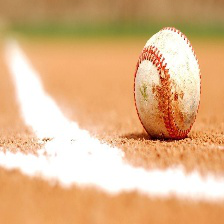

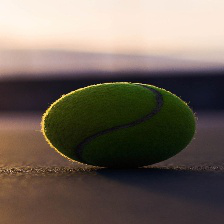

<ipython-input-24-cfea1c23edb0>:45: ComplexWarning: Casting complex values to real discards the imaginary part
  x1 = x1.astype(np.uint8)
<ipython-input-24-cfea1c23edb0>:47: ComplexWarning: Casting complex values to real discards the imaginary part
  x2 = x2.astype(np.uint8)


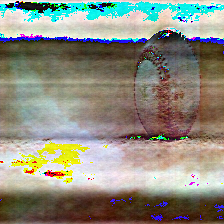

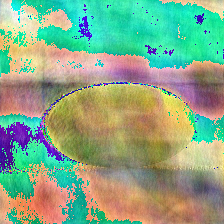

In [ ]:
x1.show()
x2.show()
APR = APRecombination()
y1,y2 = APR(x1,x2)
y1.show()
y2.show()